## TODOs
- How to implement changing injection currents?
- How to simulate many case variations?
- Single-laser IV curve

In [66]:
import numpy as np
import math
import matplotlib.pyplot as plt
from jitcdde import jitcdde, y, t
from numpy import sin, cos
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt
#from tqdm import tqdm

In [2]:
# Physical constants
e_charge = 1.602e-19  # Coulombs
c = 3e8               # Speed of light (m/s)

# Laser parameters shared by all lasers
alpha = 3.0           # Linewidth enhancement factor (dimensionless)
g = 1.2e4             # Differential gain coefficient (s^-1)
N_0 = 1.25e8          # Transparency carrier number (dimensionless)
s = 5e-7              # Saturation coefficient (dimensionless)s
gamma = 4.96e11       # Photon decay rate (s^-1)
gamma_e = 6.51e8      # Carrier decay rate (s^-1)
# See Ohtsubo pg. 37 for below details. Numbers for a InGaAsP laser
nu = 3.6              # Refractive index (dimensionless)
nu_e = 4              # Effective refractive index (dimensionless)
l = 250e-6            # Laser length (m)
tau_in = 2 * nu_e * l / c # Round trip time of light in laser cavity (s)

# Typical values for lasers (not necessarily used, but may be referenced for convenience)
wavelength_typ = 655e-9   # Laser wavelength (655 nm)
frequency_typ = c / wavelength_typ  # f = c / λ - QUESTION: shouldn't the index of refraction of the laser medium be inserted in below calculation?
omega_typ = 2 * np.pi * frequency_typ # typical laser frequency in rad/s
I_th = 17.35e-3       # Threshold current (= 17.35mA)
r_0 = (nu - 1) / (nu + 1) # Internal amplitude reflectivity for a cleaved facet (see Ohtsubo pg. 84)

### Feedback Coefficient $\kappa$

Assuming the reflectivities for the front and back facets are both $r_0$, (see Ohtsubo pg. 87)

\begin{equation}
\kappa = (1-r_0^2)\frac{r}{r_0}
\end{equation}

where $r$ is the external reflection.

### C Parameter for self-feedback

\begin{equation}
C = \frac{\kappa \tau}{\tau_{in}} \sqrt{1 + \alpha^2}
\end{equation}

When $C < 1$, the solitary laser is stable and no chaotic oscillations can be observed. (see Ohtsubo pg. 89)

In [3]:
# Sample calculations of kappa and C
r = 0.01
tau = 10e-9
print(f"Internal reflection (power): {100*r_0**2:.2f}%")
print(f"External reflection (power): {100*r**2:.2f}%")
print(f"Cavity internal round trip time (ps): {1e12 * tau_in:.2f}")
print(f"kappa = {(1 - r_0**2) * r / r_0:.4f}")
print(f"C = {((1 - r_0**2) * r / r_0) * tau * math.sqrt(1 + alpha**2) / tau_in:.2f}")

Internal reflection (power): 31.95%
External reflection (power): 0.01%
Cavity internal round trip time (ps): 6.67
kappa = 0.0120
C = 57.11


## Setup-Dependent Parameters

In [97]:
# Variables in this cell are SETUP-DEPENDENT PARAMETERS
# Number of lasers
num_lasers = 2 # CHANGE THIS

# Angular frequencies of lasers in rad/s
# Frequency differences are calculated in equations
omegas = [omega_typ for i in range(num_lasers)]

# Coupling constants
kappas = [[0 for i in range(num_lasers)] for j in range(num_lasers)] # Dimensionless coupling constant (not 1/s anymore) see Ohtsubo pg. 575
taus = [[0 for i in range(num_lasers)] for j in range(num_lasers)] # Delay time in s
# Phase should be encapsulated in the delay time
# phis = [[0 for i in range(num_lasers)] for j in range(num_lasers)]

# Injection currents in A
I_injections = [I_th for i in range(num_lasers)]

### One Laser

In [102]:
# Set constants and ICs for a single, self coupled laser
kappas[0][0] = 0.1
taus[0][0] = 10e-9
I_injections[0] = I_th + 5e-3

In [ ]:
# Initial conditions for 3 laser case
E_R_0s = [1e-6]
E_I_0s = [0]
N_init = N_0 + (I_th / e_charge - gamma_e * N_0) / gamma_e
N_0s = [N_init]

ics = []
for i in range(num_lasers):
    ics.append(E_R_0s[i])
    ics.append(E_I_0s[i])
    ics.append(N_0s[i])

### Two Lasers

In [98]:
# Two independent lasers, both biased at threshold
I_injections[0] = I_th
I_injections[1] = I_th

In [ ]:
# Two independent lasers, one biased above threshold, one biased below threshold
I_injections[0] = I_th + 1e-3
I_injections[1] = I_th - 1e-3

In [ ]:
# Two weakly coupled lasers, one biased above threshold, one biased below threshold
I_injections[0] = I_th + 1e-3
I_injections[1] = I_th - 1e-3

# Set coupling constants for 2 weakly inter-coupled lasers
kappas[0][1] = kappas[1][0] = 0.01
taus[0][1] = taus[1][0] = 10e-9

In [5]:
# Two intercoupled lasers both biased at threshold, one laser self-coupled
I_injections[0] = I_th
I_injections[1] = I_th

# Set coupling constants for 2 weakly inter-coupled lasers
kappas[0][1] = kappas[1][0] = 0.01
taus[0][1] = taus[1][0] = 10e-9

# Make laser #0 couple to itself too
kappas[0][0] = 0.01
taus[0][0] = 50e-9

In [99]:
# Initial conditions for 2 laser case (can be used for any of above cases)
E_R_0s = [1e-6, 1e-6]
E_I_0s = [0, 0]
N_init = N_0 + (I_th / e_charge - gamma_e * N_0) / gamma_e
N_0s = [N_init, N_init]

# Introduce some asymmetry in initial conditions
E_R_0s[0] += 10e-6
E_R_0s[1] -= 10e-6

ics = []
for i in range(num_lasers):
    ics.append(E_R_0s[i])
    ics.append(E_I_0s[i])
    ics.append(N_0s[i])

### Three Lasers

In [ ]:
# Set coupling constants for 3 independent, weakly self-coupled lasers
kappas[0][0] = 0.01
kappas[1][1] = 0.01
kappas[2][2] = 0.01

taus[0][0] = 3.65e-9
taus[1][1] = 3.65e-9
taus[2][2] = 3.65e-9

for row in kappas:
    print(row)

for row in taus:
    print(row)

In [212]:
# Set coupling constants for 3 weakly intercoupled coupled lasers
# Question: is kappa unitless or 1/s? (divided by tau_in?)
kappas[0][1] = kappas[1][0] = 1e7

taus[0][1] = taus[1][0] = 3.65e-9

for row in kappas:
    print(row)

for row in taus:
    print(row)

[0, 10000000.0, 0]
[10000000.0, 0, 0]
[0, 0, 0]
[0, 3.65e-09, 0]
[3.65e-09, 0, 0]
[0, 0, 0]


In [6]:
# Observe changes in injection current (3 independent lasers)
#I_injections = [I_th + 10e-3 for x in I_injections]
I_injections[1] += 1e-3
I_injections[2] += 10e-3

print(I_injections)

[0.01735, 0.01835, 0.02735]


In [8]:
# Set INITIAL CONDITIONS required for DDE solver
# Initial conditions for 3 laser case
E_R_0s = [1e-6, 1e-6, 1e-6]
E_I_0s = [0, 0, 0]
N_init = N_0 + (I_th / e_charge - gamma_e * N_0) / gamma_e
N_0s = [N_init, N_init, N_init]

# Introduce some asymmetry in initial conditions
#E_R_0s[1] += 10e-6
#E_R_0s[2] -= 10e-6

ics = []
for i in range(num_lasers):
    ics.append(E_R_0s[i])
    ics.append(E_I_0s[i])
    ics.append(N_0s[i])

### Lang-Kobayashi Equations

For a system of n lasers, the differential equations for laser $j$ are given by:

Question: is it plus alpha or minus alpha? see Ohtsubo 87

i'm assuming its minus alpha here, according to Ohtsubo

\begin{equation}
\frac{dE_j(t)}{dt} = \frac{1}{2} (1 - i \alpha) (G_j - \gamma) E_j(t) + \frac{\kappa_{jj}}{\tau_{in}} E_j(t - \tau_{jj}) \text{exp}(i \omega_j \tau_{jj})+ \sum^{n - 1}_{k=0, k\neq j} \frac{\kappa_{jk}}{\tau_{in}} E_k(t - \tau_{jk}) \text{exp}(-i \Delta\omega_{jk} \tau_{jk})
\end{equation}

where 

$\kappa_{jk}$ is the coupling strength from k to j

$\tau_{jk}$ is the time delay from k to j

$\Delta\omega_{jk} = \omega_k - \omega_j$

We keep individual frequencies. See Ohtsubo pg. 186 for explanation of where the $i\Delta\omega E$ term comes from. Chixuan uses this but I do not.

The first term on the right is increase in field from the laser's own field.
The second term on the right is the self coupling of the laser (has a delay $\tau_{jj}$).
The third term on the right is the coupling from all other lasers.

To code this, we have to break up the above expression for E into a real component $X_j(t)$ and imaginary component $Y_j(t)$ such that $E_j(t) = X_j(t) + i Y_j(t)$.

\begin{equation}
\frac{dE_j(t)}{dt} = \frac{1}{2}  (G_j - \gamma) E_j(t) - i \alpha \frac{1}{2}  (G_j - \gamma) E_j(t) + \frac{\kappa_{jj}}{\tau_{in}} E_j(t - \tau_{jj}) \cos(\omega_j \tau_{jj}) + i \frac{\kappa_{jj}}{\tau_{in}} E_j(t - \tau_{jj}) \sin(\omega_j \tau_{jj}) + \sum^{n - 1}_{k=0, k\neq j} \frac{\kappa_{jk}}{\tau_{in}} E_k(t - \tau_{jk}) \cos(\Delta\omega_{jk} \tau_{jk}) - i \sum^{n - 1}_{k=0, k\neq j} \frac{\kappa_{jk}}{\tau_{in}} E_k(t - \tau_{jk}) \sin(\Delta\omega_{jk} \tau_{jk})
\end{equation}

After we expand $E$ into $X$ and $Y$ and distribute terms, (check against Chixuan slide 11, since signs differ due to the alpha convention)

\begin{equation}
\frac{dX_j(t)}{dt} = \frac{1}{2}  (G_j - \gamma) (X_j(t) + \alpha Y_j(t)) + \frac{\kappa_{jj}}{\tau_{in}} (X_j(t - \tau_{jj}) \cos(\omega_j \tau_{jj}) - Y_j(t - \tau_{jj}) \sin(\omega_j \tau_{jj})) + \sum^{n - 1}_{k=0, k\neq j} \frac{\kappa_{jk}}{\tau_{in}} ( X_k(t - \tau_{jk}) \cos(\Delta\omega_{jk} \tau_{jk}) + Y_k(t - \tau_{jk}) \sin(\Delta\omega_{jk} \tau_{jk}))
\end{equation}

\begin{equation}
\frac{dY_j(t)}{dt} = \frac{1}{2}  (G_j - \gamma) (Y_j(t) - \alpha X_j(t)) + \frac{\kappa_{jj}}{\tau_{in}} (Y_j(t - \tau_{jj}) \cos(\omega_j \tau_{jj}) + X_j(t - \tau_{jj}) \sin(\omega_j \tau_{jj})) + \sum^{n - 1}_{k=0, k\neq j} \frac{\kappa_{jk}}{\tau_{in}} ( Y_k(t - \tau_{jk}) \cos(\Delta\omega_{jk} \tau_{jk}) - X_k(t - \tau_{jk}) \sin(\Delta\omega_{jk} \tau_{jk}))
\end{equation}

For the carrier density of laser $j$,
\begin{equation}
\frac{dN_j(t)}{dt} = \frac{I_j}{e} - \gamma_e * N_j - G_j * |E|^2
\end{equation}

Where $|E|^2 = X^2 + Y^2$.

We aren't missing a cavity leaking term gamma in the above equation since the carrier density doesn't depend on that.

In [9]:
# Generates Lang-Kobayashi Differential Equations for a system of lasers of specified parameters
# Returns equations in order: laser #1 real E, laser #1 imaginary E, laser #1 carrier density, laser #2 real E, ...
def generate_equations(num_lasers, omegas, kappas, taus, I_injections):
    # State variables 
    # Each laser has 3 independent variables: real component of E field, imaginary component of E field, and carrier density
    # in total there are num_lasers*3 variables
    E_Rs = [] # Real part of electric field
    E_Is = [] # Imaginary part of electric field
    Ns = [] # Carrier density
    
    for i in range(num_lasers):
        E_Rs.append(y(i * 3))
        E_Is.append(y(i * 3 + 1))
        Ns.append(y(i * 3 + 2))
    
    #print(f"E_Rs: {E_Rs}, E_Is: {E_Is}, Ns: {Ns}")
    
    # Delayed variables are added in the equation itself
    
    # The intensity and gain are dependent on E and N
    intensities = []
    gains = []
    
    # Intensities
    for i in range(num_lasers):
        intensities.append(E_Rs[i]**2 + E_Is[i]**2)
    
    # Net Gains
    for i in range(num_lasers):
        gains.append( (g * (Ns[i] - N_0) / (1 + s * intensities[i])) ) 
    
    # Equations for derivatives
    dE_R_dts = []
    dE_I_dts = []
    dN_dts = []
    
    for j in range(num_lasers):
        dE_R_dt = (1/2) * (gains[j] - gamma) * (E_Rs[j] + alpha * E_Is[j])
        dE_R_dt += (kappas[j][j] / tau_in) * ( y(j * 3, t - taus[j][j]) * cos(omegas[j] * taus[j][j]) - y(j * 3 + 1, t - taus[j][j]) * sin(omegas[j] * taus[j][j]) )
        for k in range(num_lasers):
            if j == k:
                continue
            delta_omega = omegas[k] - omegas[j]
            dE_R_dt += (kappas[j][k] / tau_in) * ( y(k * 3, t - taus[j][k]) * cos(delta_omega * taus[j][k]) + y(k * 3 + 1, t - taus[j][k]) * sin(delta_omega * taus[j][k]) )
        dE_R_dts.append(dE_R_dt)
        
        dE_I_dt = (1/2) * (gains[j] - gamma) * (E_Is[j] - alpha * E_Rs[j])
        dE_I_dt += (kappas[j][j] / tau_in) * ( y(j * 3 + 1, t - taus[j][j]) * cos(omegas[j] * taus[j][j]) + y(j * 3, t - taus[j][j]) * sin(omegas[j] * taus[j][j]) )
        for k in range(num_lasers):
            if j == k:
                continue
            delta_omega = omegas[k] - omegas[j]
            dE_I_dt += (kappas[j][k] / tau_in) * ( y(k * 3 + 1, t - taus[j][k]) * cos(delta_omega * taus[j][k]) - y(k * 3, t - taus[j][k]) * sin(delta_omega * taus[j][k]) )
        dE_I_dts.append(dE_I_dt)
    
        dN_dt = (I_injections[j] / e_charge) - gamma_e * Ns[j] - gains[j] * intensities[j]
        dN_dts.append(dN_dt)
    
    #print(f"dE_R_dts: {dE_R_dts}, dE_I_dts: {dE_I_dts}, dN_dts: {dN_dts}")
    
    equations = []
    for i in range(num_lasers):
        equations.append(dE_R_dts[i])
        equations.append(dE_I_dts[i])
        equations.append(dN_dts[i])

    return equations

## Run Simulation

In [100]:
# Simulation parameters
# Time parameters
t_start = 0.0
t_end = 1000e-9  # Total simulation time in seconds (1000ns)
dt = 0.01e-9     # Time step in seconds (0.01ns)

In [101]:
# Initialize the solver
dde = jitcdde(generate_equations(num_lasers, omegas, kappas, taus, I_injections))

# Solve the system
# Set maximum delay
# If integration doesn't work, try reducing min_step or loosening tolerances
#dde.set_integration_parameters(rtol=1e-4, atol=1e-6)
dde.set_integration_parameters(rtol=1e-4, atol=1e-6, min_step=1e-15)
#dde.set_integration_parameters(min_step=1e-15)
    
dde.constant_past(ics)

# Start the simulation
dde.step_on_discontinuities()

# Time array
times = np.arange(t_start, t_end, dt)
times_ns = times * 1e9
outputs = []

for time in times:
    state = dde.integrate(time)
    outputs.append(state)

print("Finished solving system.")

outputs = np.array(outputs)

# Extract results from output
E_R_ts = []
E_I_ts = []
N_ts = []

for i in range(num_lasers):
    E_R_ts.append(outputs[:, i * 3])
    E_I_ts.append(outputs[:, i * 3 + 1])
    N_ts.append(outputs[:, i * 3 + 2])

# Compute intensities
I_ts = []
for i in range(num_lasers):
    I_ts.append(E_R_ts[i]**2 + E_I_ts[i]**2)

# Remove initial transients
#transient_cutoff = int(0.2 * len(I1_t))
#I1_t_trimmed = I1_t[transient_cutoff:]
#I2_t_trimmed = I2_t[transient_cutoff:]
#times_trimmed = times[transient_cutoff:]

#cross_corr_values = []
#phase_sync_indices = []
    
# Compute cross-correlation
#corr = np.correlate(I1_t_trimmed - np.mean(I1_t_trimmed), I2_t_trimmed - np.mean(I2_t_trimmed), mode='full')
#max_corr = np.max(corr)
#cross_corr_values.append(max_corr)

# Phase synchronization analysis
# phi_1_t = np.unwrap(np.arctan2(E_I1_t[transient_cutoff:], E_R1_t[transient_cutoff:]))
# phi_2_t = np.unwrap(np.arctan2(E_I2_t[transient_cutoff:], E_R2_t[transient_cutoff:]))
# delta_phi_t = phi_1_t - phi_2_t
# R = np.abs(np.mean(np.exp(1j * delta_phi_t)))
# phase_sync_indices.append(R)

Generating, compiling, and loading C code.


/home/godwin/Documents/Summer 2025/Research/lasersim/.venv/lib64/python3.13/site-packages/jitcxde_common/_jitcxde.py:248: UserWarning: Differential equation does not include a delay term.
  self.compile_C()
/tmp/ipykernel_2867517/1539855525.py:22: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  state = dde.integrate(time)


Finished solving system.


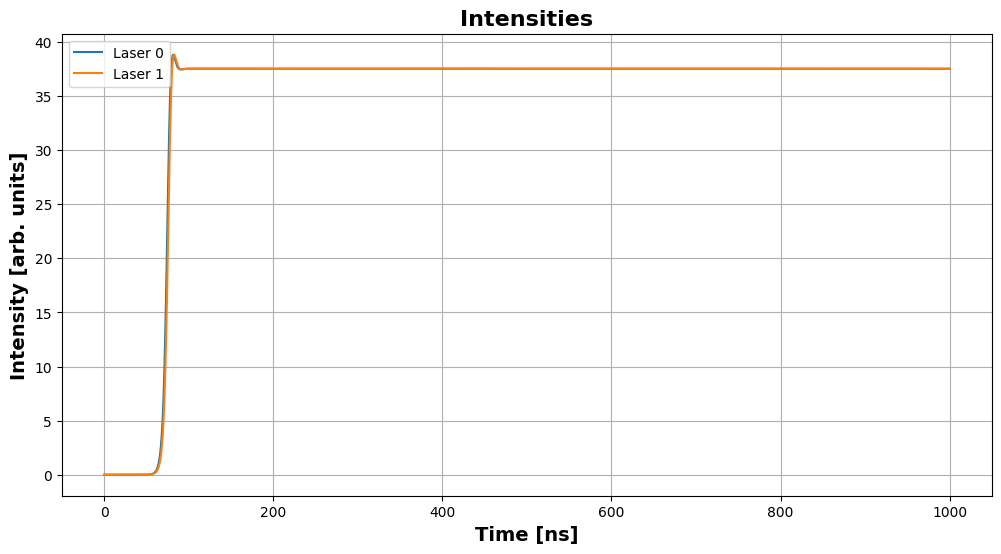

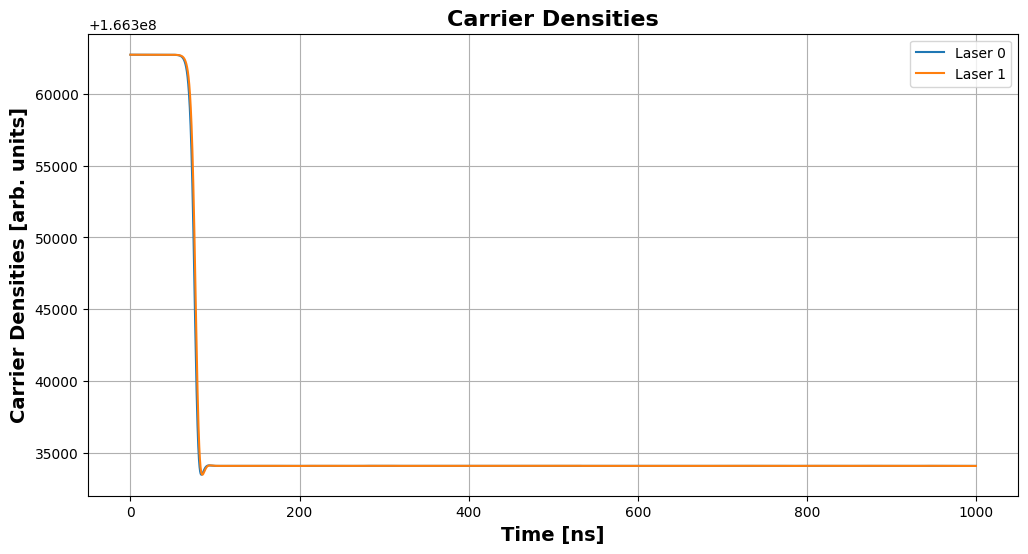

In [108]:
# Plot intensities over the entire time interval
plt.figure(figsize=(12, 6))

for i in range(num_lasers):
    plt.plot(times_ns, I_ts[i], label=f"Laser {i}")
    
plt.xlabel("Time [ns]", fontsize=14, fontweight='bold')
plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Intensities",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

plt.savefig('2laser_independent_threshold_intensity.png')
plt.show()

# Plot carrier densities over the entire time interval
plt.figure(figsize=(12, 6))
for i in range(num_lasers):
    plt.plot(times_ns, N_ts[i], label=f"Laser {i}")
    
plt.xlabel("Time [ns]", fontsize=14, fontweight='bold')
plt.ylabel("Carrier Densities [arb. units]", fontsize=14, fontweight='bold')
plt.title("Carrier Densities",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

#plt.savefig('2laser_0p012kappa_10ns_intercouple_0p012kappa_50ns_l0selfcouple_17mA_carrierdensity.png')
plt.show()

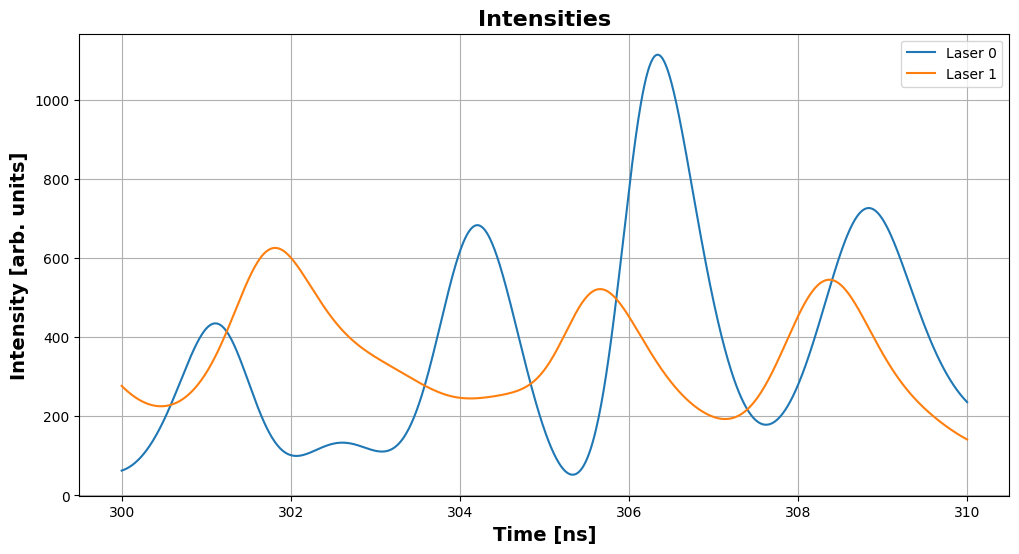

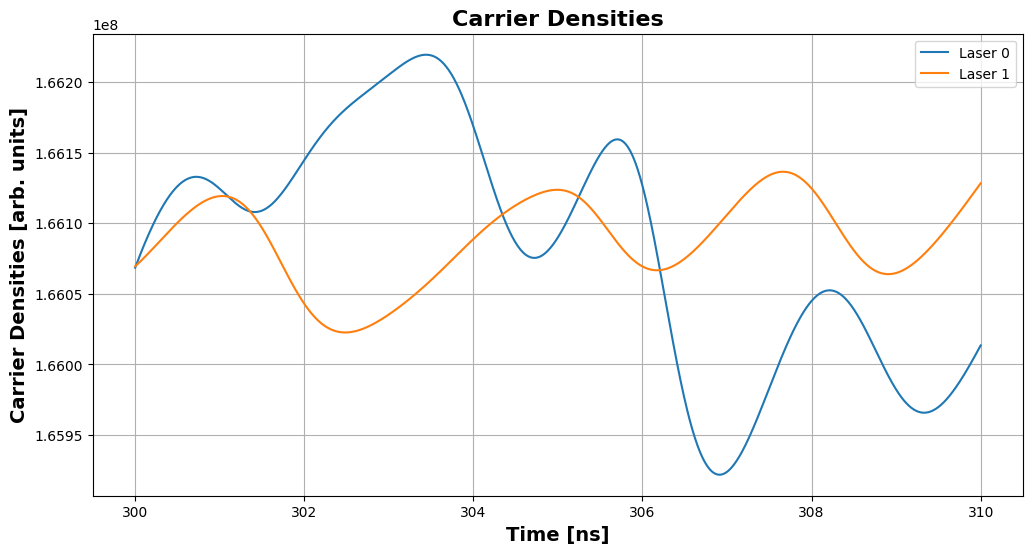

In [72]:
# Plot intensities over shortened time interval
begin_time = 300 # in ns
end_time = 310 # in ns

plt.figure(figsize=(12, 6))
for i in range(num_lasers):
    plt.plot(times_ns[(times_ns >= begin_time) & (times_ns <= end_time)], I_ts[i][(times_ns >= begin_time) & (times_ns <= end_time)], label=f"Laser {i}")
plt.xlabel("Time [ns]", fontsize=14, fontweight='bold')
plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Intensities",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

plt.show()

# Plot carrier densities over shortened time interval
plt.figure(figsize=(12, 6))
for i in range(num_lasers):
    plt.plot(times_ns[(times_ns >= begin_time) & (times_ns <= end_time)], N_ts[i][(times_ns >= begin_time) & (times_ns <= end_time)], label=f"Laser {i}")
plt.xlabel("Time [ns]", fontsize=14, fontweight='bold')
plt.ylabel("Carrier Densities [arb. units]", fontsize=14, fontweight='bold')
plt.title("Carrier Densities",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

plt.show()

## FFT Analysis

In [103]:
# Take FFT of all intensity spectrums for entire time period
freqs = rfftfreq(len(times), dt)
freqs_mhz = freqs / 1e6

spectrums = []
for i in range(num_lasers):
    c_spectrum = rfft(I_ts[i])
    mag_spectrum = np.abs(c_spectrum)
    mag_spectrum = mag_spectrum / len(freqs_mhz) # Divide by N to normalize the result
    spectrums.append(mag_spectrum)

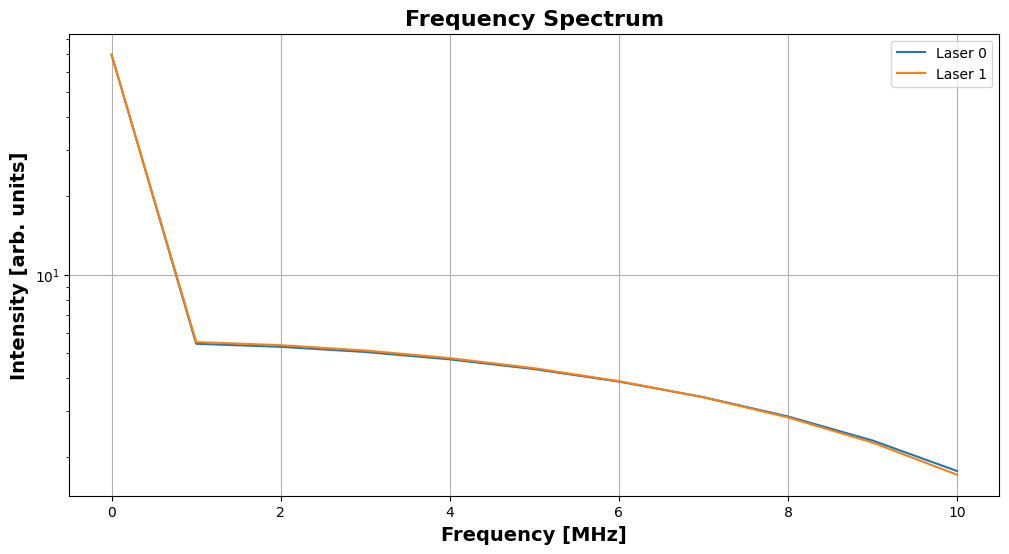

Avg value of laser 0: 6.96e+01
Avg value of laser 1: 6.95e+01


In [104]:
# Plot frequency spectrum in certain range
plt.figure(figsize=(12, 6))
begin_freq = 0 # in MHz
end_freq = 10 # in MHz

for i in range(num_lasers):
    plt.plot(freqs_mhz[(freqs_mhz >= begin_freq) & (freqs_mhz <= end_freq)], spectrums[i][(freqs_mhz >= begin_freq) & (freqs_mhz <= end_freq)], label=f"Laser {i}")

# Logarithmic y axis
plt.yscale('log')
plt.xlabel("Frequency [MHz]", fontsize=14, fontweight='bold')
plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Frequency Spectrum",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

#plt.savefig('2laser_0p012kappa_10ns_intercouple_0p012kappa_50ns_l0selfcouple_17mA_intensity.png')
plt.show()

# Print average (DC) value
for i in range(num_lasers):
    print(f"Avg value of laser {i}: {spectrums[i][0]:.2e}")

## Lowpass Filter to emulate photodetector response

In [105]:
# This code snippet from https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / (0.5 * fs) # Divide by Nyquist frequency
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [106]:
# Filter parameters
cutoff_freq = 10e6 # in Hz
order = 1 # first order butterworth filter, like a simple RC filter. Increase for better filter performance

filtered_I_ts = []
for i in range(num_lasers):
    filtered_I_ts.append(butter_lowpass_filter(I_ts[i], cutoff_freq, 1 / dt, order))

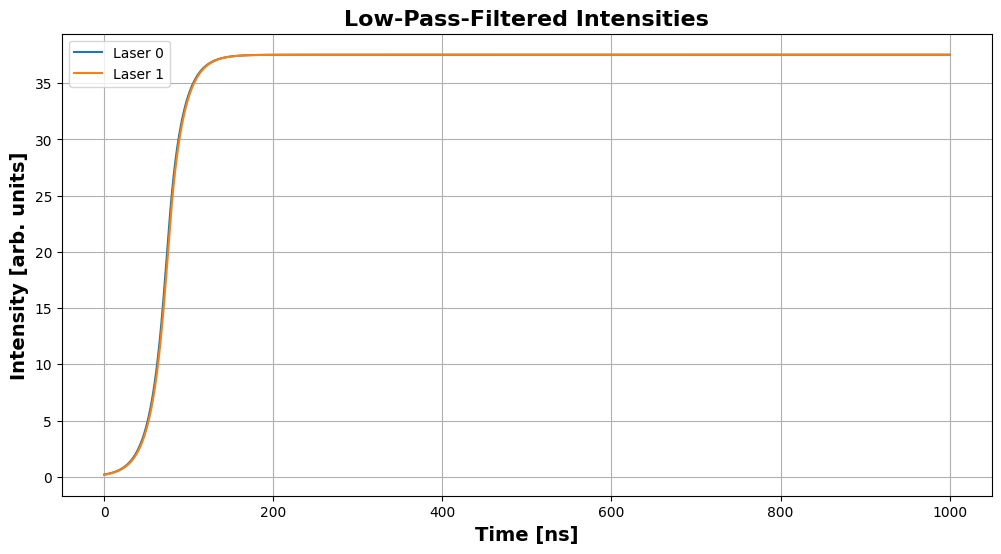

In [107]:
# Plot filtered intensities over the entire time interval
plt.figure(figsize=(12, 6))

for i in range(num_lasers):
    plt.plot(times_ns, filtered_I_ts[i], label=f"Laser {i}")
    
plt.xlabel("Time [ns]", fontsize=14, fontweight='bold')
plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Low-Pass-Filtered Intensities",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

#plt.savefig('2laser_0p012kappa_10ns_intercouple_0p012kappa_50ns_l0selfcouple_17mA_intensity.png')
plt.show()

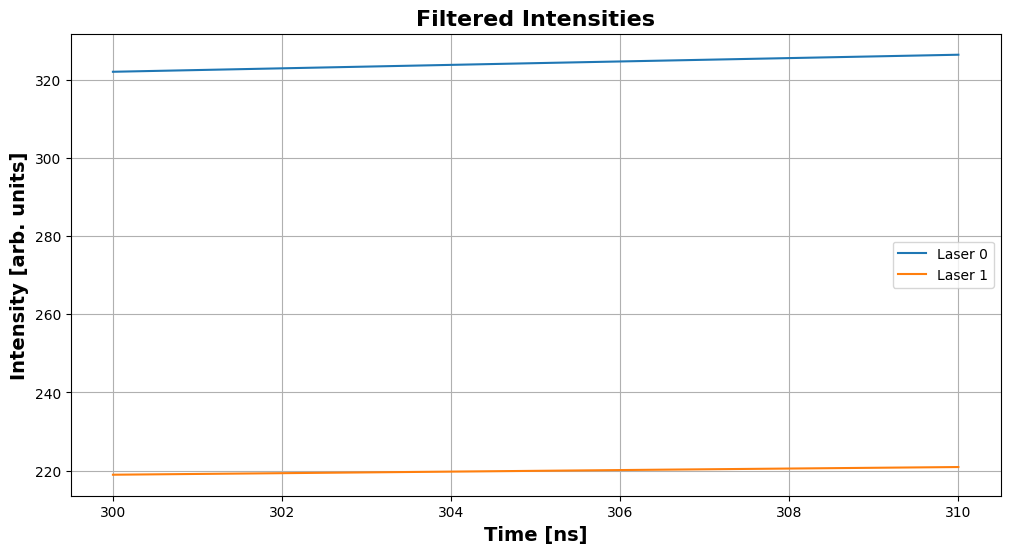

In [75]:
# Plot filtered intensities over shortened time interval
begin_time = 300 # in ns
end_time = 310 # in ns

plt.figure(figsize=(12, 6))
for i in range(num_lasers):
    plt.plot(times_ns[(times_ns >= begin_time) & (times_ns <= end_time)], filtered_I_ts[i][(times_ns >= begin_time) & (times_ns <= end_time)], label=f"Laser {i}")
plt.xlabel("Time [ns]", fontsize=14, fontweight='bold')
plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Low-Pass-Filtered Intensities",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

plt.show()